In [1]:
%load_ext autoreload
%autoreload 2

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/home/daniel/Documents/attention_equivariant/equivariant-attention


In [9]:
from models import rotation_attention, positional_encodings, vanilla_attention
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps, animation
rng = jax.random.PRNGKey(seed=1)
rngs = jax.random.split(rng, 10)

In [39]:
n_samples = 10
n_keys = 5
n_group_samples = 10
d = 2

key_reps = rotation_attention.group_samples(n_group_samples, 1)

value_reps = rotation_attention.group_samples(n_group_samples, 0)
keys = jax.random.normal(rngs[1], shape = [n_keys, d + 1])
values = jax.random.normal(rngs[2], shape = [n_keys, d])

X_train = positional_encodings.uniform_ball_samples(rngs[0], n_samples, d = d, r = 1.)
X_train_encoded = positional_encodings.positional_encoding(X_train, method = "stereographic")

X_test = positional_encodings.uniform_ball_samples(rngs[1], n_samples, d = d, r = 1.)
X_test_encoded = positional_encodings.positional_encoding(X_test, method = "stereographic")

rotation = rotation_attention.group_samples(360, 0)[57]
f = lambda x : rotation @ x * jnp.linalg.norm(x)


Y_train = jax.vmap(f)(X_train)
noise = jax.random.normal(rngs[2], shape=Y_train.shape) * 0.1
Y_test = jax.vmap(f)(X_test)

In [40]:
rotation

Array([[ 0.54463893, -0.8386706 ],
       [ 0.8386706 ,  0.54463893]], dtype=float32)

In [41]:
stereographic_encoding = lambda v: positional_encodings.positional_encoding(
    v, method="stereographic"
)
# init_values = jnp.stack([jnp.linspace(0, 1, num = n_keys), jnp.zeros([n_keys])], axis = -1)
# init_keys = stereographic_encoding(jnp.stack([jnp.zeros([n_keys]), jnp.linspace(0, 1, num = n_keys)], axis = -1)) * 5
n_epochs = 10000

keys_hist, values_hist, key_reps, value_reps, betas_hist = rotation_attention.train(
    rngs[3],
    X_train,
    stereographic_encoding,
    n_keys,
    n_group_samples,
    n_epochs=n_epochs,
    lr=1.0,
    Y_train=Y_train + noise, 
    verbose=True,
    # init_values=init_values,
    # init_keys=init_keys,
    init_beta = 1.
)

van_keys_hist, van_values_hist, van_betas_hist = vanilla_attention.train(
    rngs[3],
    stereographic_encoding(X_train),
    n_keys * n_group_samples,
    n_epochs=n_epochs,
    lr=1.0,
    Y_train=Y_train + noise, 
    verbose=True,
    # init_values=init_values,
    # init_keys=init_keys,
    init_beta = 1.
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

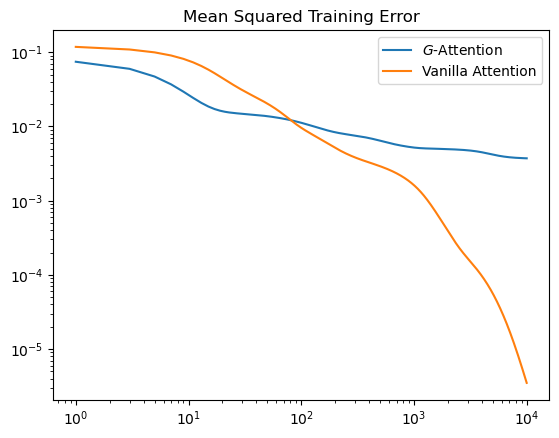

In [42]:
step_size = 2
van_loss_hist = vanilla_attention.batched_loss(
    stereographic_encoding(X_train),
    Y_train + noise,
    van_keys_hist[1::step_size],
    van_values_hist[1::step_size],
    van_betas_hist[1::step_size],
)
loss_hist = rotation_attention.batched_loss(
    X_train_encoded,
    Y_train + noise,
    keys_hist[1::step_size],
    key_reps,
    values_hist[1::step_size],
    value_reps,
    betas_hist[1::step_size],
)
fig, ax = plt.subplots()

ax.plot(jnp.arange(1, keys_hist.shape[0], step_size), loss_hist, label="$G$-Attention")
ax.plot(jnp.arange(1, van_keys_hist.shape[0], step_size), van_loss_hist, label="Vanilla Attention")
ax.set(xscale="log", yscale="log", title="Mean Squared Training Error")
plt.legend()

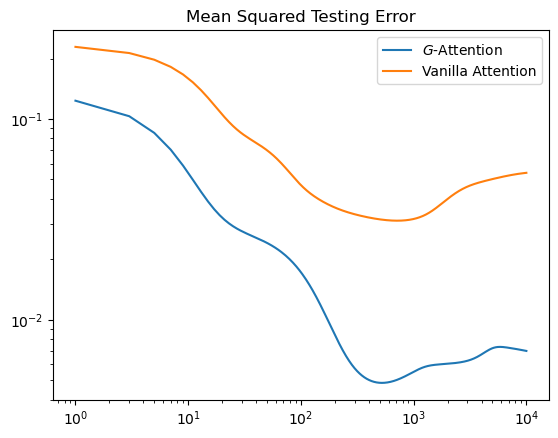

In [43]:
step_size = 2
van_test_loss_hist = vanilla_attention.batched_loss(
    X_test_encoded,
    Y_test,
    van_keys_hist[1::step_size],
    van_values_hist[1::step_size],
    van_betas_hist[1::step_size],
)
test_loss_hist = rotation_attention.batched_loss(
    X_test_encoded,
    Y_test,
    keys_hist[1::step_size],
    key_reps,
    values_hist[1::step_size],
    value_reps,
    betas_hist[1::step_size],
)
fig, ax = plt.subplots()

ax.plot(jnp.arange(1, keys_hist.shape[0], step_size), test_loss_hist, label="$G$-Attention")
ax.plot(jnp.arange(1, van_keys_hist.shape[0], step_size), van_test_loss_hist, label="Vanilla Attention")
ax.set(xscale="log", yscale="log", title="Mean Squared Testing Error")
plt.legend()

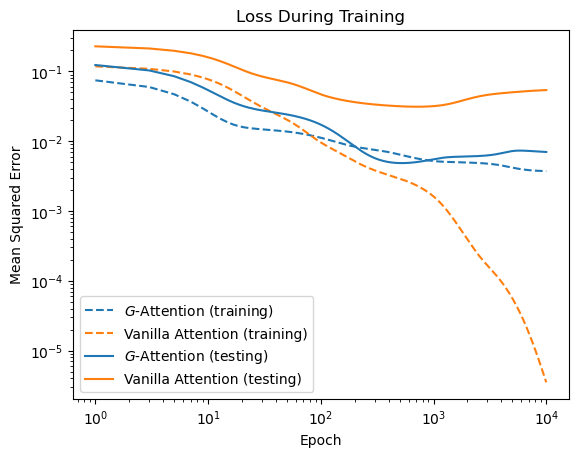

In [44]:

fig, ax = plt.subplots()
ax.plot(jnp.arange(1, keys_hist.shape[0], step_size), loss_hist, label="$G$-Attention (training)", linestyle="--", color = "C0")
ax.plot(jnp.arange(1, van_keys_hist.shape[0], step_size), van_loss_hist, label="Vanilla Attention (training)", linestyle="--", color = "C1")
ax.plot(jnp.arange(1, keys_hist.shape[0], step_size), test_loss_hist, label="$G$-Attention (testing)", color = "C0")
ax.plot(jnp.arange(1, van_keys_hist.shape[0], step_size), van_test_loss_hist, label="Vanilla Attention (testing)", color = "C1")
ax.set(xscale="log", yscale="log", title="Loss During Training", xlabel="Epoch", ylabel="Mean Squared Error")
plt.legend()
plt.savefig("figures/attention_comparison.png")

[Text(0, 0.5, 'β'), Text(0.5, 0, 'epoch'), None]

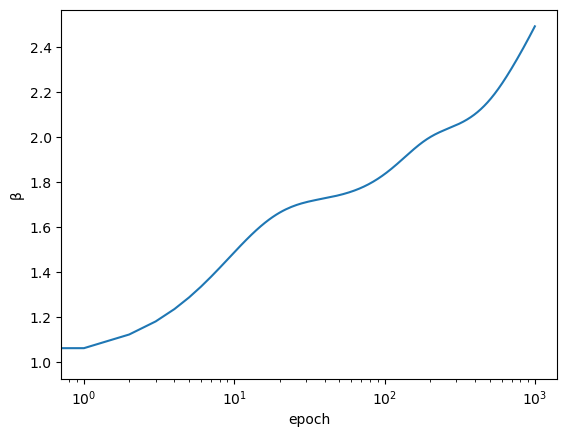

In [6]:
fig, ax = plt.subplots()

ax.plot(
    jnp.arange(betas_hist.shape[0]),
    betas_hist
)

ax.set(ylabel="\u03B2", xlabel = "epoch", xscale = "log")

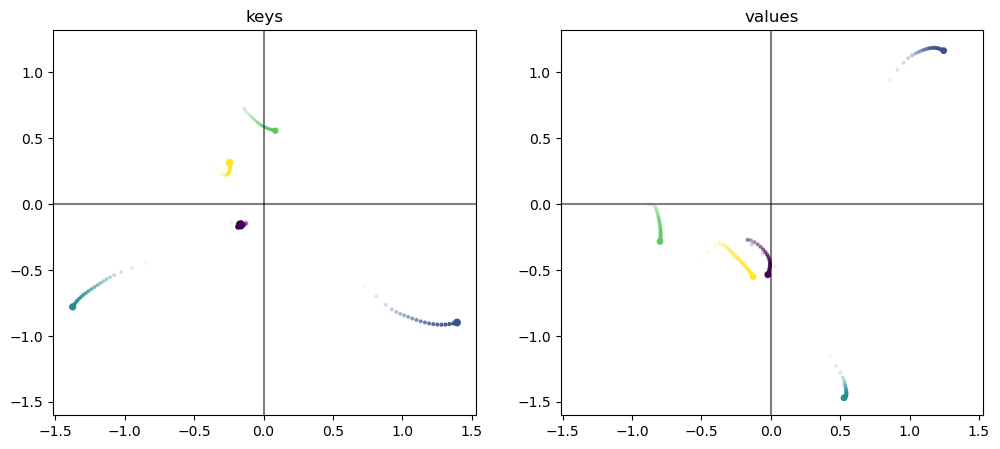

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cmap = colormaps.get_cmap("viridis")


keys_hist_norms = jnp.linalg.norm(keys_hist, axis = -1)
keys_hist_decoded = jax.vmap(
    lambda x: positional_encodings.positional_decoding(x, method="stereographic"), 0
)(keys_hist / keys_hist_norms[:, :, None])

for i in range(0, keys_hist.shape[0], int(keys_hist.shape[0] / 20)):
    axs[0].scatter(
        keys_hist_decoded[i, :, 0],
        keys_hist_decoded[i, :, 1],
        alpha=(i / keys_hist.shape[0]),
        color=cmap(jnp.linspace(0, 1, num=n_keys)),
        s=jnp.exp(keys_hist_norms[i]),
    )
    axs[1].scatter(
        values_hist[i, :, 0],
        values_hist[i, :, 1],
        alpha=(i / keys_hist.shape[0]),
        color=cmap(jnp.linspace(0, 1, num=n_keys)),
        s=4,
    )

axs[0].scatter(
    keys_hist_decoded[-1, :, 0],
    keys_hist_decoded[-1, :, 1],
    color=cmap(jnp.linspace(0, 1, num=n_keys)),
    s=5 * jnp.exp(keys_hist_norms[i]),
)

axs[1].scatter(
    values_hist[-1, :, 0],
    values_hist[-1, :, 1],
    color=cmap(jnp.linspace(0, 1, num=n_keys)),
    s = 15
)

axs[0].set(title = "keys")
axs[1].set(title = "values")

axs[0].get_ylim()

def get_containing_lims(axs):
    min_x, min_y, max_x, max_y = 1, 1, -1, -1
    for ax in axs:
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()

        min_x = min(min_x, x_min)
        min_y = min(min_y, y_min)
        max_x = max(max_x, x_max)
        max_y = max(max_y, y_max)
    return (min_x, max_x), (min_y, max_y)

x_lims, y_lims = get_containing_lims(axs)
for ax in axs:
    ax.set(xlim=x_lims, ylim=y_lims)
    ax.axhline(y=0, color="black", alpha = 0.5)
    ax.axvline(x=0, color="black", alpha = 0.5)

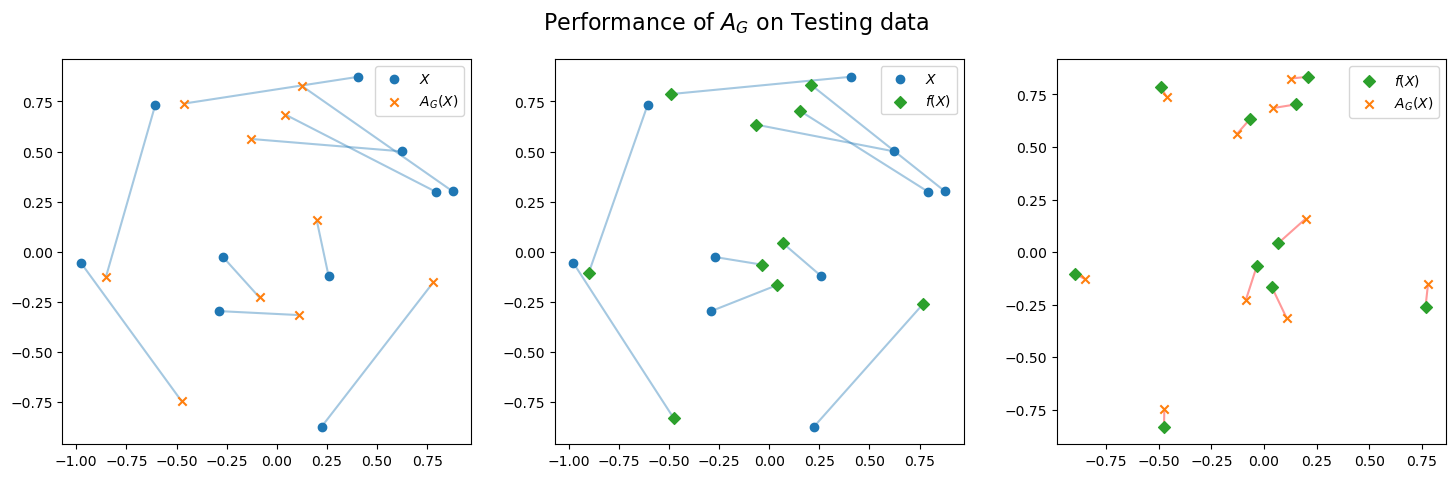

In [58]:
X_test_pred = rotation_attention.batched_call_fn(
    X_test_encoded,
    keys_hist[-1],
    key_reps,
    values_hist[-1],
    value_reps,
    betas_hist[-1],
)

X_train_pred = rotation_attention.batched_call_fn(
    X_train_encoded,
    keys_hist[-1],
    key_reps,
    values_hist[-1],
    value_reps,
    betas_hist[-1],
)

fig, axs = rotation_attention.plot_predictions(X_test, X_test_pred, Y_test)
fig.suptitle("Performance of $A_G$ on Testing data", fontsize = 16)
plt.savefig("figures/g_attention_test.png")
# plt.savefig("figures/van_attention_test.png")
# fig, axs = rotation_attention.plot_predictions(X_train, X_train_pred, Y_train + noise)
# fig.suptitle("Training data (with noise)")

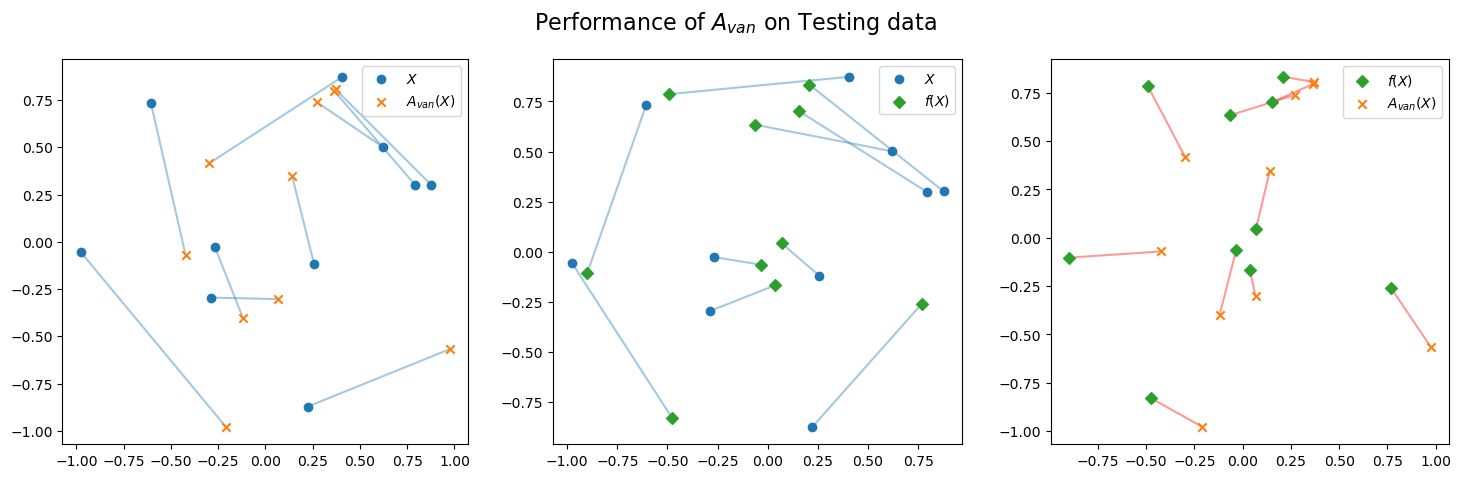

In [59]:
van_X_test_pred = vanilla_attention.batched_call_fn(
    X_test_encoded,
    van_keys_hist[-1],
    van_values_hist[-1],
    van_betas_hist[-1],
)

van_X_train_pred = vanilla_attention.batched_call_fn(
    X_train_encoded,
    van_keys_hist[-1],
    van_values_hist[-1],
    van_betas_hist[-1],
)

fig, axs = rotation_attention.plot_predictions(X_test, van_X_test_pred, Y_test, func_name="A_{van}")
fig.suptitle("Performance of $A_{van}$ on Testing data", fontsize=16)
plt.savefig("figures/van_attention_test.png")

MovieWriter ffmpeg unavailable; using Pillow instead.


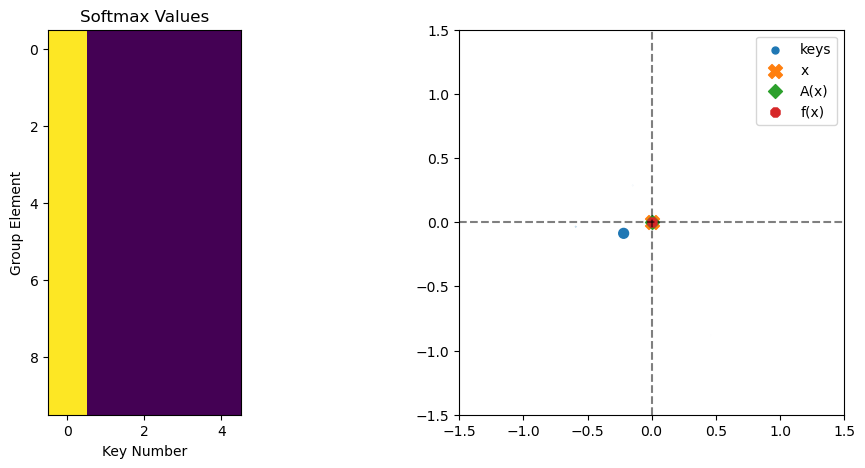

In [46]:
x = jnp.array([0.75, 0])


rotations = rotation_attention.group_samples(360, 0)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
def func(frame):
  for ax in axs:
    ax.clear()
  
  if frame < 100:
    gx = rotations[frame] @ x * (frame / 100)
  else:
    gx = rotations[100 + (4 * (frame - 100))] @ x
  scores = rotation_attention.scores(stereographic_encoding(gx)[0], keys_hist[-1], key_reps, betas_hist[-1])
  Ax = rotation_attention.call_fn(stereographic_encoding(gx)[0], keys_hist[-1], key_reps, values_hist[-1], value_reps, betas_hist[-1])
  fx = f(gx)
  axs[0].imshow(scores.T)
  axs[0].set(xlabel = "Key Number", ylabel = "Group Element", title = "Softmax Values")
  axs[1].axhline(y = 0, alpha = 0.5, color='black', linestyle='--')
  axs[1].axvline(x = 0, alpha = 0.5, color='black', linestyle='--')
  axs[1].scatter(keys_hist[-1, :, 0], keys_hist[-1, :, 1], s=50 * scores.sum(axis=1), color = "C0", label="keys")
  axs[1].scatter(gx[None, 0], gx[None, 1], color = "C1", marker="X", s = 100, label = "x")
  axs[1].scatter(Ax[None, 0], Ax[None, 1], color = "C2", marker="D", s = 50, label = "A(x)")
  axs[1].scatter(fx[None, 0], fx[None, 1], color = "C3", marker="8", s = 50, label = "f(x)")
  axs[1].set(aspect='equal', xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
  axs[1].legend()
  return axs

# anim = animation.FuncAnimation(fig, func, 300, interval = 2, repeat=True)
# anim.save("test.gif")

In [61]:
from properties import equivariance

func = lambda v: rotation_attention.call_fn(v, keys_hist[-1], key_reps, values_hist[-1], value_reps, betas_hist[-1])

domain_reps = rotation_attention.group_samples(1_000, 1)
codomain_reps = rotation_attention.group_samples(1_000, 0)

equivariance_losses = equivariance.check_equivariance(func, stereographic_encoding(X_train)[0], domain_reps, codomain_reps)
# orbit_x = jnp.sum(key_reps * (stereographic_encoding(X_train))[0][None, None, :], axis = -1)

In [66]:
# plt.plot(equivariance_losses)

for i in range(10):
    equivariance_losses = equivariance.check_equivariance(func, stereographic_encoding(X_train)[i], domain_reps, codomain_reps)
    print(jnp.max(equivariance_losses))

0.00014964143
0.00015978969
0.00013666821
8.805565e-07
0.00018835273
3.9452917e-07
5.0422324e-07
2.2860731e-05
5.0774764e-07
5.597127e-06
